In [8]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


#### References
\
Wiin-Nielsen, A. (1991). The birth of numerical weather prediction. Tellus A: Dynamic Meteorology and Oceanography, 43(4), 36–52. https://doi.org/10.3402/tellusa.v43i4.1193 \
Yang, R., Hu, J., Li, Z., et al. (2024). Interpretable machine learning for weather and climate prediction: A review. Atmospheric Environment, 338, 120797. https://doi.org/10.1016/j.atmosenv.2024.120797 \
Tyralis, H., & Papacharalampous, G. (2017). Variable Selection in Time Series Forecasting Using Random Forests. Algorithms, 10(4), 114; https://doi.org/10.3390/a10040114 \
Zhang, W. Y., Xie, J. F., Wan, G. C., & Tong, M. S. (2021). Single-step and multi-step time series prediction for urban temperature based on LSTM model of TensorFlow. 2021 Photonics & Electromagnetics Research Symposium (PIERS), 1531–1535. https://doi.org/10.1109/PIERS53385.2021.9694882

#### How our approach addressed their limitations:

In Study A (Tyralis & Papacharalampous), random forests used raw lags and lacked interpretability-focused pruning. We addressed this by adding time-aware engineered features and applying feature pruning to improve clarity and generalisation. \
In Study B (Zhang et al.), the LSTM lacked systematic hyperparameter tuning and baseline ML comparisons. We improved on this by tuning across multiple horizons and benchmarking against tree-based models for interpretability and performance. \
Study C (Yang et al.) emphasized the need for interpretable weather ML models. Our project uses tree-based models like RF and XGB to balance performance with explainability through feature importance and pruning.

# Data pre-processing

## Inspecting Data

In [ ]:
df = pd.read_csv('../data/weather_data.csv')
df.info()
df.head(24) # to see 1 whole day

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100057 entries, 0 to 100056
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   temperature                100057 non-null  float64
 1   wind_speed                 100057 non-null  float64
 2   mean_sea_level_pressure    100057 non-null  float64
 3   surface_solar_radiation    100057 non-null  float64
 4   surface_thermal_radiation  100057 non-null  float64
 5   total_cloud_cover          100057 non-null  float64
 6   relative_humidity          100057 non-null  float64
dtypes: float64(7)
memory usage: 5.3 MB


,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity
0,18.26,2.60,101046.38,287.01,408.35,1.00,0.89
1,18.67,2.91,101037.96,360.79,411.02,1.00,0.86
2,18.16,3.26,101017.26,291.54,410.67,1.00,0.87
3,18.46,3.17,101022.56,357.11,410.95,1.00,0.82
4,18.53,2.95,100940.03,459.91,410.00,0.90,0.80
5,18.92,2.62,100885.16,513.07,407.46,0.96,0.79
6,19.22,2.87,100825.28,312.21,411.98,0.94,0.77
7,19.41,3.01,100801.35,211.40,406.76,0.90,0.76
8,19.67,2.72,100817.06,112.08,404.20,0.89,0.74
9,20.28,1.94,100834.75,57.45,401.17,0.89,0.71


In [4]:
df.describe()

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity
count,100057.000000,100057.000000,100057.000000,100057.000000,100057.000000,100057.000000,100057.000000
mean,14.802318,3.909783,101613.132937,182.921098,324.615891,0.587394,0.729192
std,5.575031,2.050064,925.846843,265.316443,32.930795,0.356411,0.158500
min,0.860000,0.020000,96725.920000,0.000000,232.150000,0.000000,0.120000
25%,10.830000,2.300000,101169.940000,0.000000,300.510000,0.270000,0.620000
50%,13.920000,3.670000,101703.710000,7.220000,322.900000,0.650000,0.760000
75%,18.000000,5.280000,102201.650000,316.230000,347.150000,0.940000,0.850000
max,40.360000,13.230000,103397.530000,1112.140000,458.760000,1.000000,1.090000


There are 7 columns and 100057 rows. All columns are continuous and numeric. There are no null values in the data frame.

In [5]:
df[df['relative_humidity']>1]

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity
16008,11.93,6.70,101736.07,505.92,340.45,0.88,1.03
27210,13.40,0.45,101310.55,0.00,353.59,0.78,1.01
27232,13.23,0.57,101305.03,0.00,318.06,0.02,1.01
27233,13.18,0.93,101281.83,0.00,316.88,0.03,1.03
27234,12.49,0.75,101271.51,0.00,317.32,0.02,1.06
27235,12.16,0.87,101301.08,0.00,326.12,0.01,1.09
27236,12.46,1.14,101331.64,2.24,320.53,0.06,1.05
27237,13.05,1.17,101365.41,100.50,327.53,0.07,1.03
27282,9.92,4.54,102009.52,0.00,288.93,0.00,1.02
27283,9.43,4.35,101980.19,0.00,284.20,0.01,1.04


Since almost all of these humidities are recorded in Feb 2013 (and 1 in 2011), we can treat it as an isolated phenomenon and strictly predict relative humidity levels between 0 and 1.

Hence, we replace the relative humidity in these rows with 1.

In [6]:
df['relative_humidity'] = df['relative_humidity'].apply(lambda x: min(x, 1))

To more easily relate the data to real life, in terms of season etc., we insert a date_time column.

In [7]:
# add time column

df_time = df.copy()
df_time['date_time'] = pd.date_range(start='1/1/2010 11:00:00', periods=100057, freq='h', tz='Australia/Sydney')
df_time.head(24)

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity,date_time
0,18.26,2.60,101046.38,287.01,408.35,1.00,0.89,2010-01-01 11:00:00+11:00
1,18.67,2.91,101037.96,360.79,411.02,1.00,0.86,2010-01-01 12:00:00+11:00
2,18.16,3.26,101017.26,291.54,410.67,1.00,0.87,2010-01-01 13:00:00+11:00
3,18.46,3.17,101022.56,357.11,410.95,1.00,0.82,2010-01-01 14:00:00+11:00
4,18.53,2.95,100940.03,459.91,410.00,0.90,0.80,2010-01-01 15:00:00+11:00
5,18.92,2.62,100885.16,513.07,407.46,0.96,0.79,2010-01-01 16:00:00+11:00
6,19.22,2.87,100825.28,312.21,411.98,0.94,0.77,2010-01-01 17:00:00+11:00
7,19.41,3.01,100801.35,211.40,406.76,0.90,0.76,2010-01-01 18:00:00+11:00
8,19.67,2.72,100817.06,112.08,404.20,0.89,0.74,2010-01-01 19:00:00+11:00
9,20.28,1.94,100834.75,57.45,401.17,0.89,0.71,2010-01-01 20:00:00+11:00


# Correlation Analysis

<Axes: >

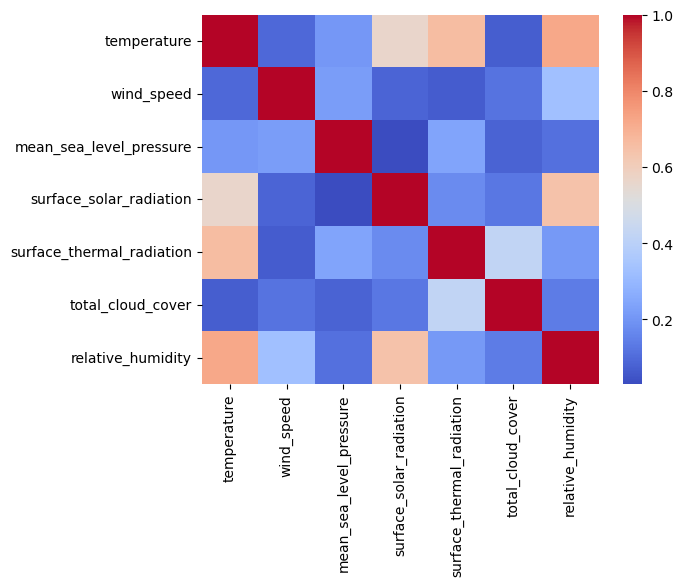

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr().abs()
sns.heatmap(corr, cmap="coolwarm")


# Time series visualizations >:)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

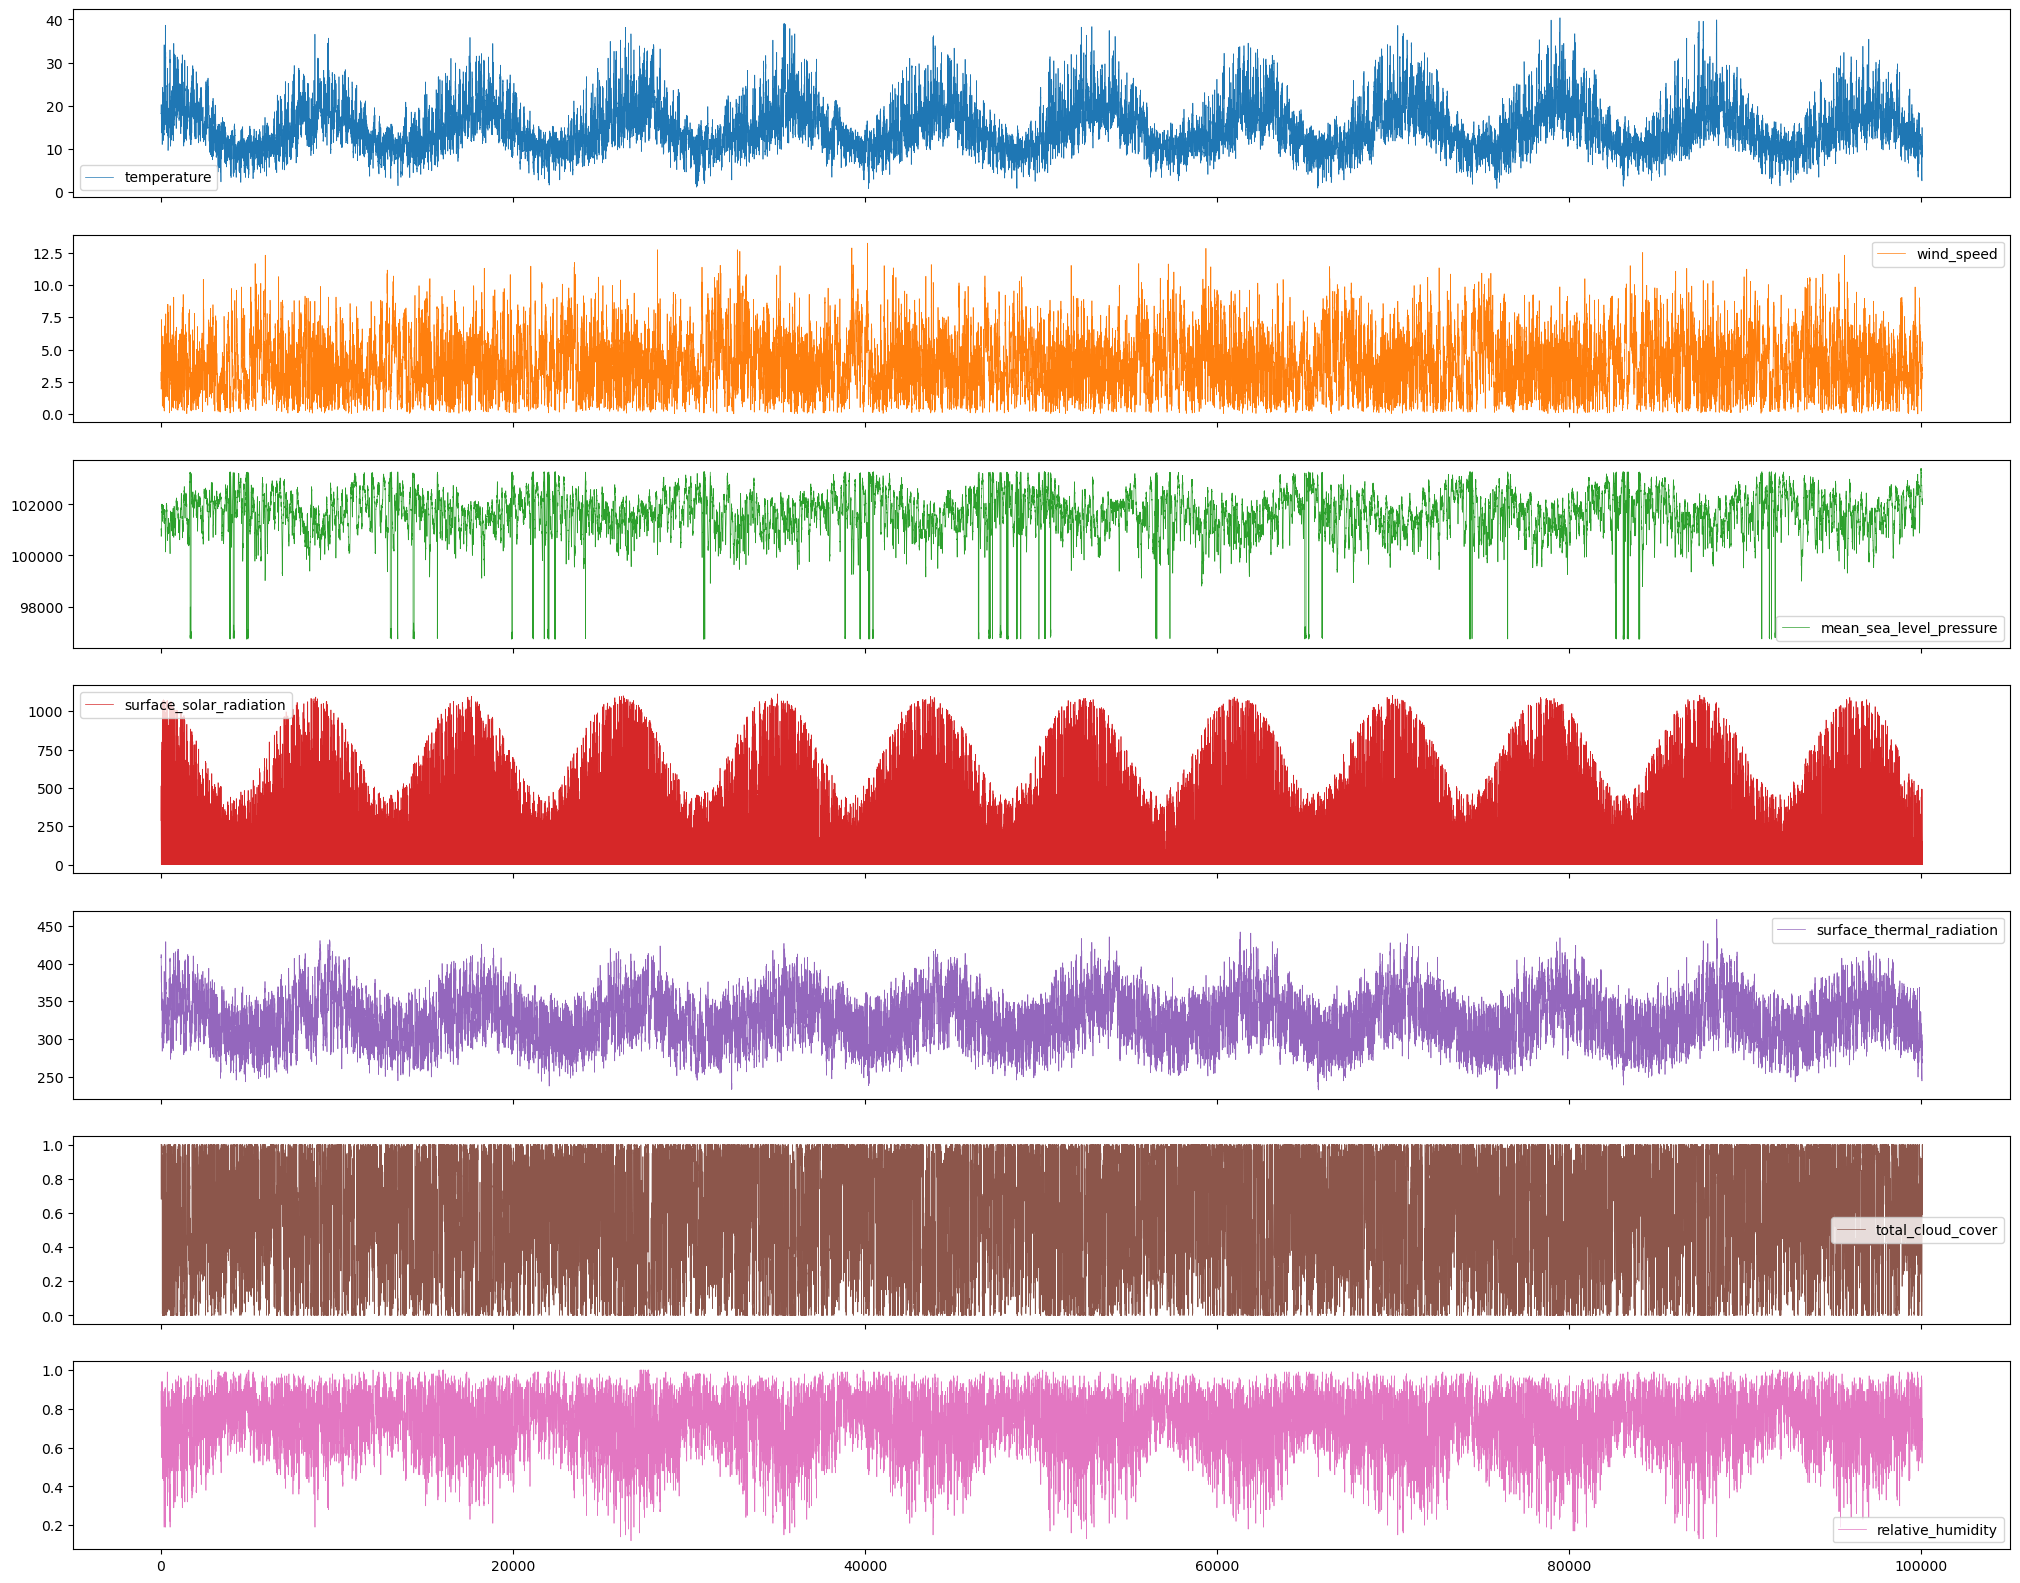

In [8]:
df.plot(subplots=True, figsize=(25,20), linewidth=0.5)

In [9]:
def plot_columns(cols, w):
    df_means = pd.DataFrame()
    for col in cols:
        df_col = df[col].rolling(window=w).mean()
        new_col_name = col + "_mean"
        df_means[new_col_name] = df_col
    df_means.plot(subplots=True, figsize=(25,20))

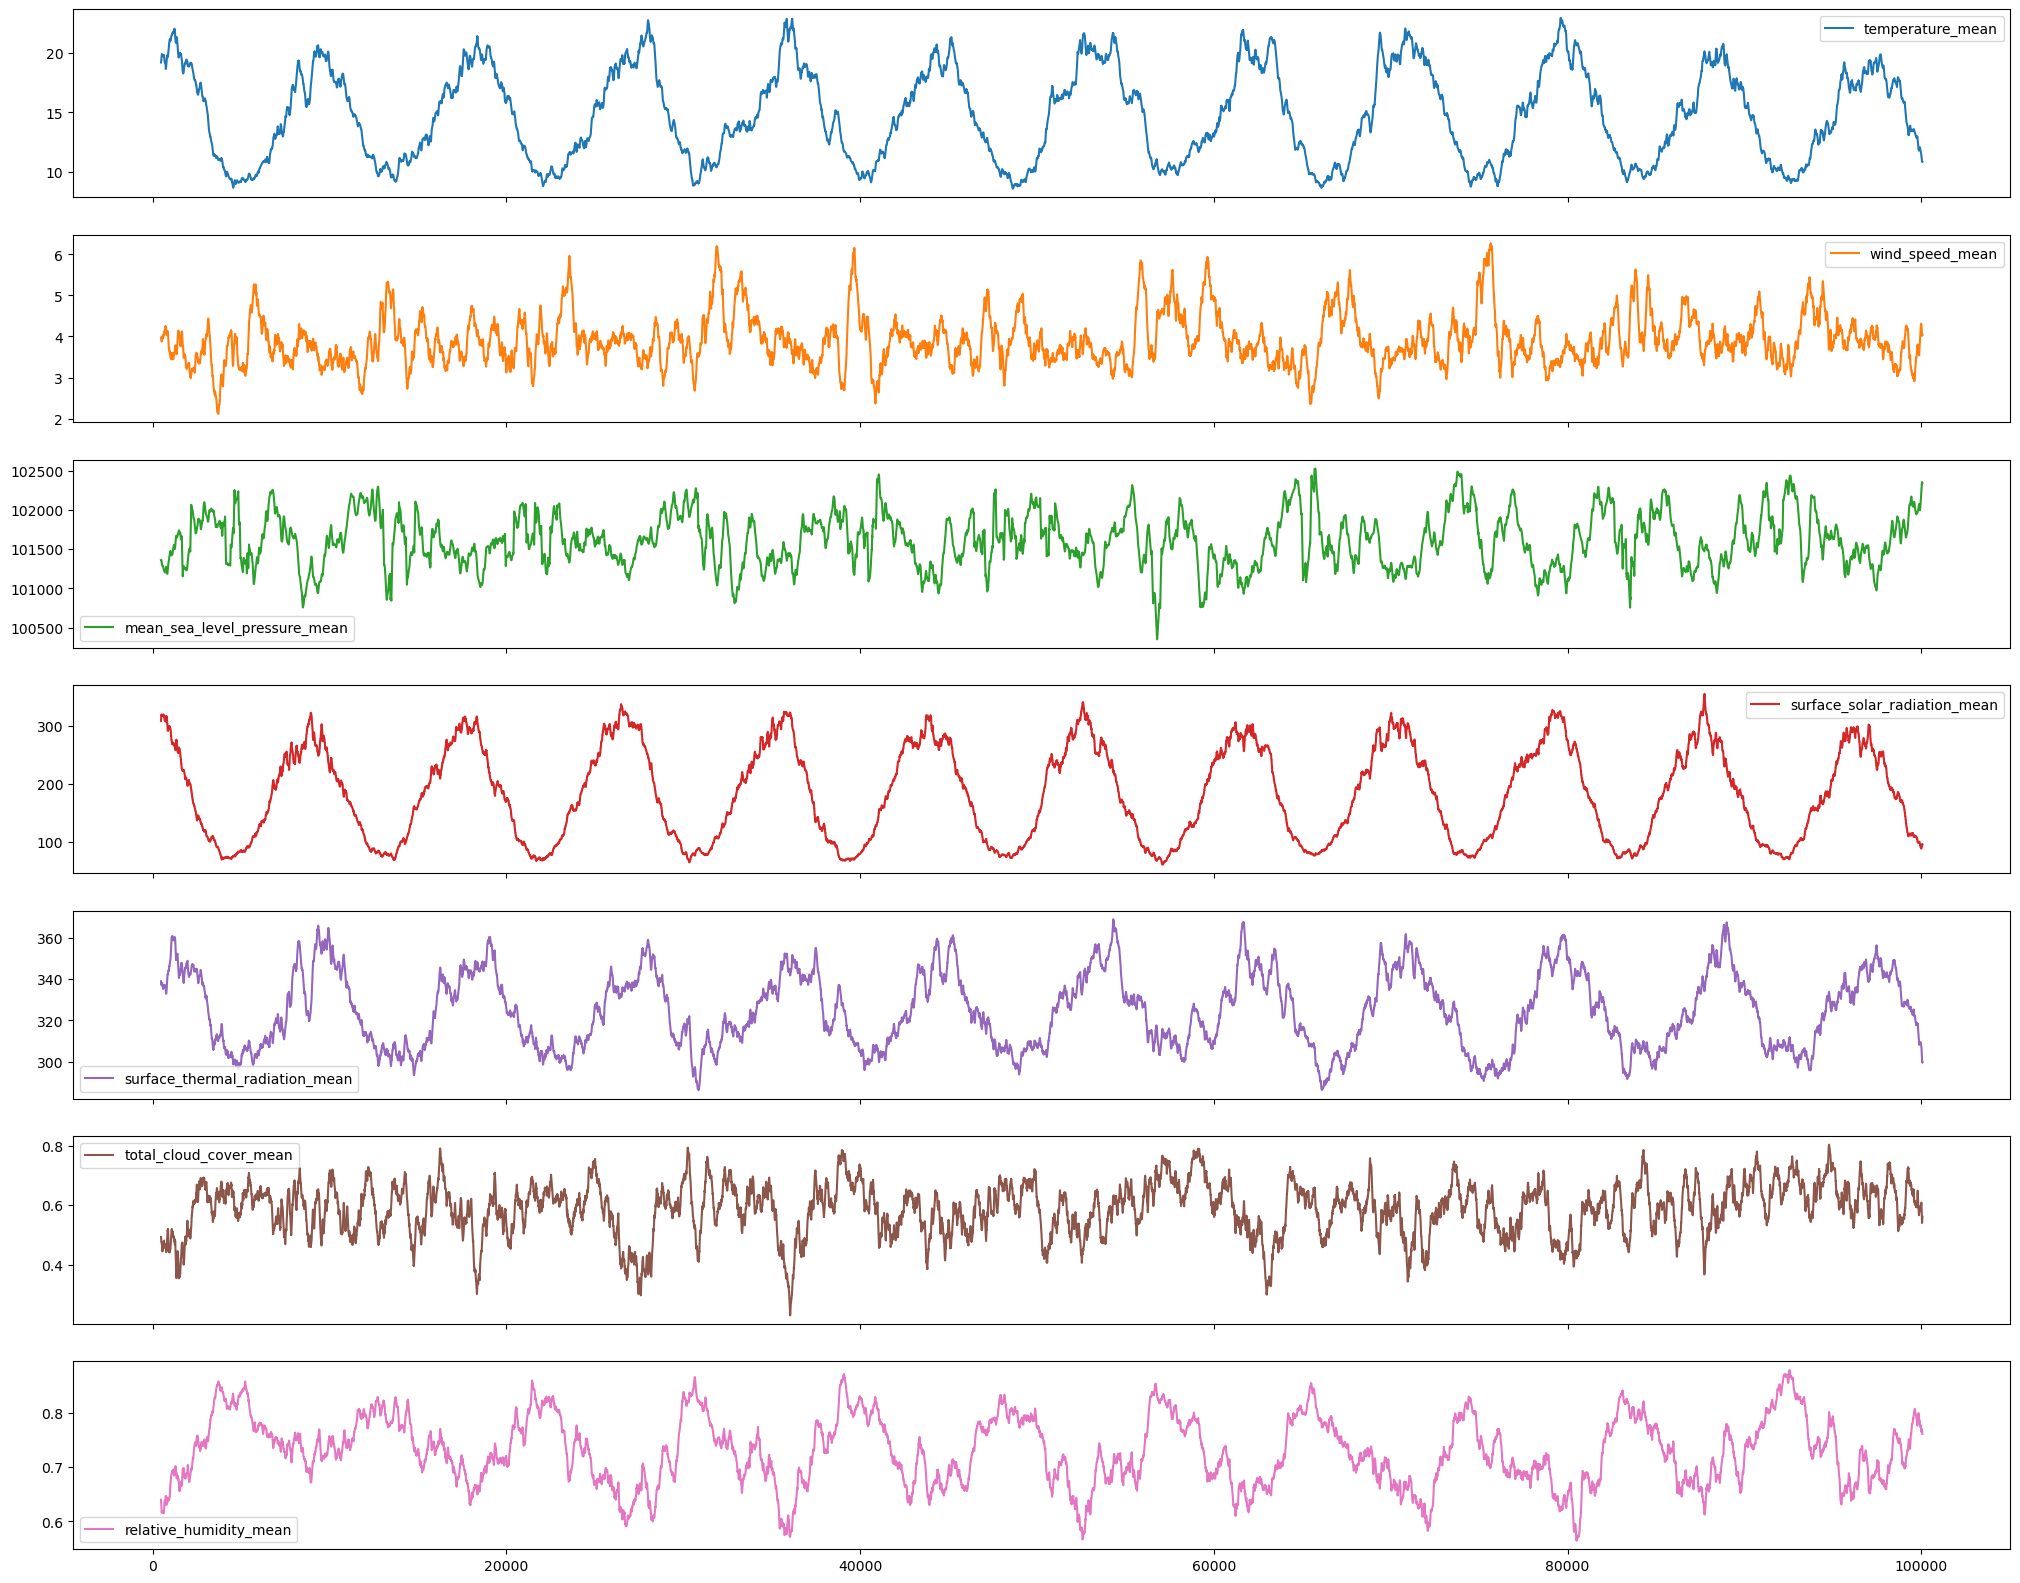

In [10]:
plot_columns(df.columns, 480) 

# Stationarity Test

In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    results = {}
    for column in df.columns:
        print(f"Running ADF test for column: {column}")
        adf_result = adfuller(df[column].dropna())  # Drop NaN values for testing
        results[column] = {
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Stationary": adf_result[1] < 0.05  # True if p-value < 0.05
        }
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print("Stationary:", "Yes" if adf_result[1] < 0.05 else "No")
        print("-" * 50)
    return pd.DataFrame(results).T

# Example usage:
# Assuming `df` is your DataFrame with time series data
stationarity_results = check_stationarity(df)
print(stationarity_results)




Running ADF test for column: temperature
ADF Statistic: -13.297648129081466
p-value: 7.152232838571214e-25
Stationary: Yes
--------------------------------------------------
Running ADF test for column: wind_speed
ADF Statistic: -28.95821197714215
p-value: 0.0
Stationary: Yes
--------------------------------------------------
Running ADF test for column: mean_sea_level_pressure
ADF Statistic: -28.872760286711024
p-value: 0.0
Stationary: Yes
--------------------------------------------------
Running ADF test for column: surface_solar_radiation
ADF Statistic: -13.100616205818875
p-value: 1.7129623691806974e-24
Stationary: Yes
--------------------------------------------------
Running ADF test for column: surface_thermal_radiation
ADF Statistic: -20.401482267703468
p-value: 0.0
Stationary: Yes
--------------------------------------------------
Running ADF test for column: total_cloud_cover
ADF Statistic: -43.6816132144696
p-value: 0.0
Stationary: Yes
--------------------------------------

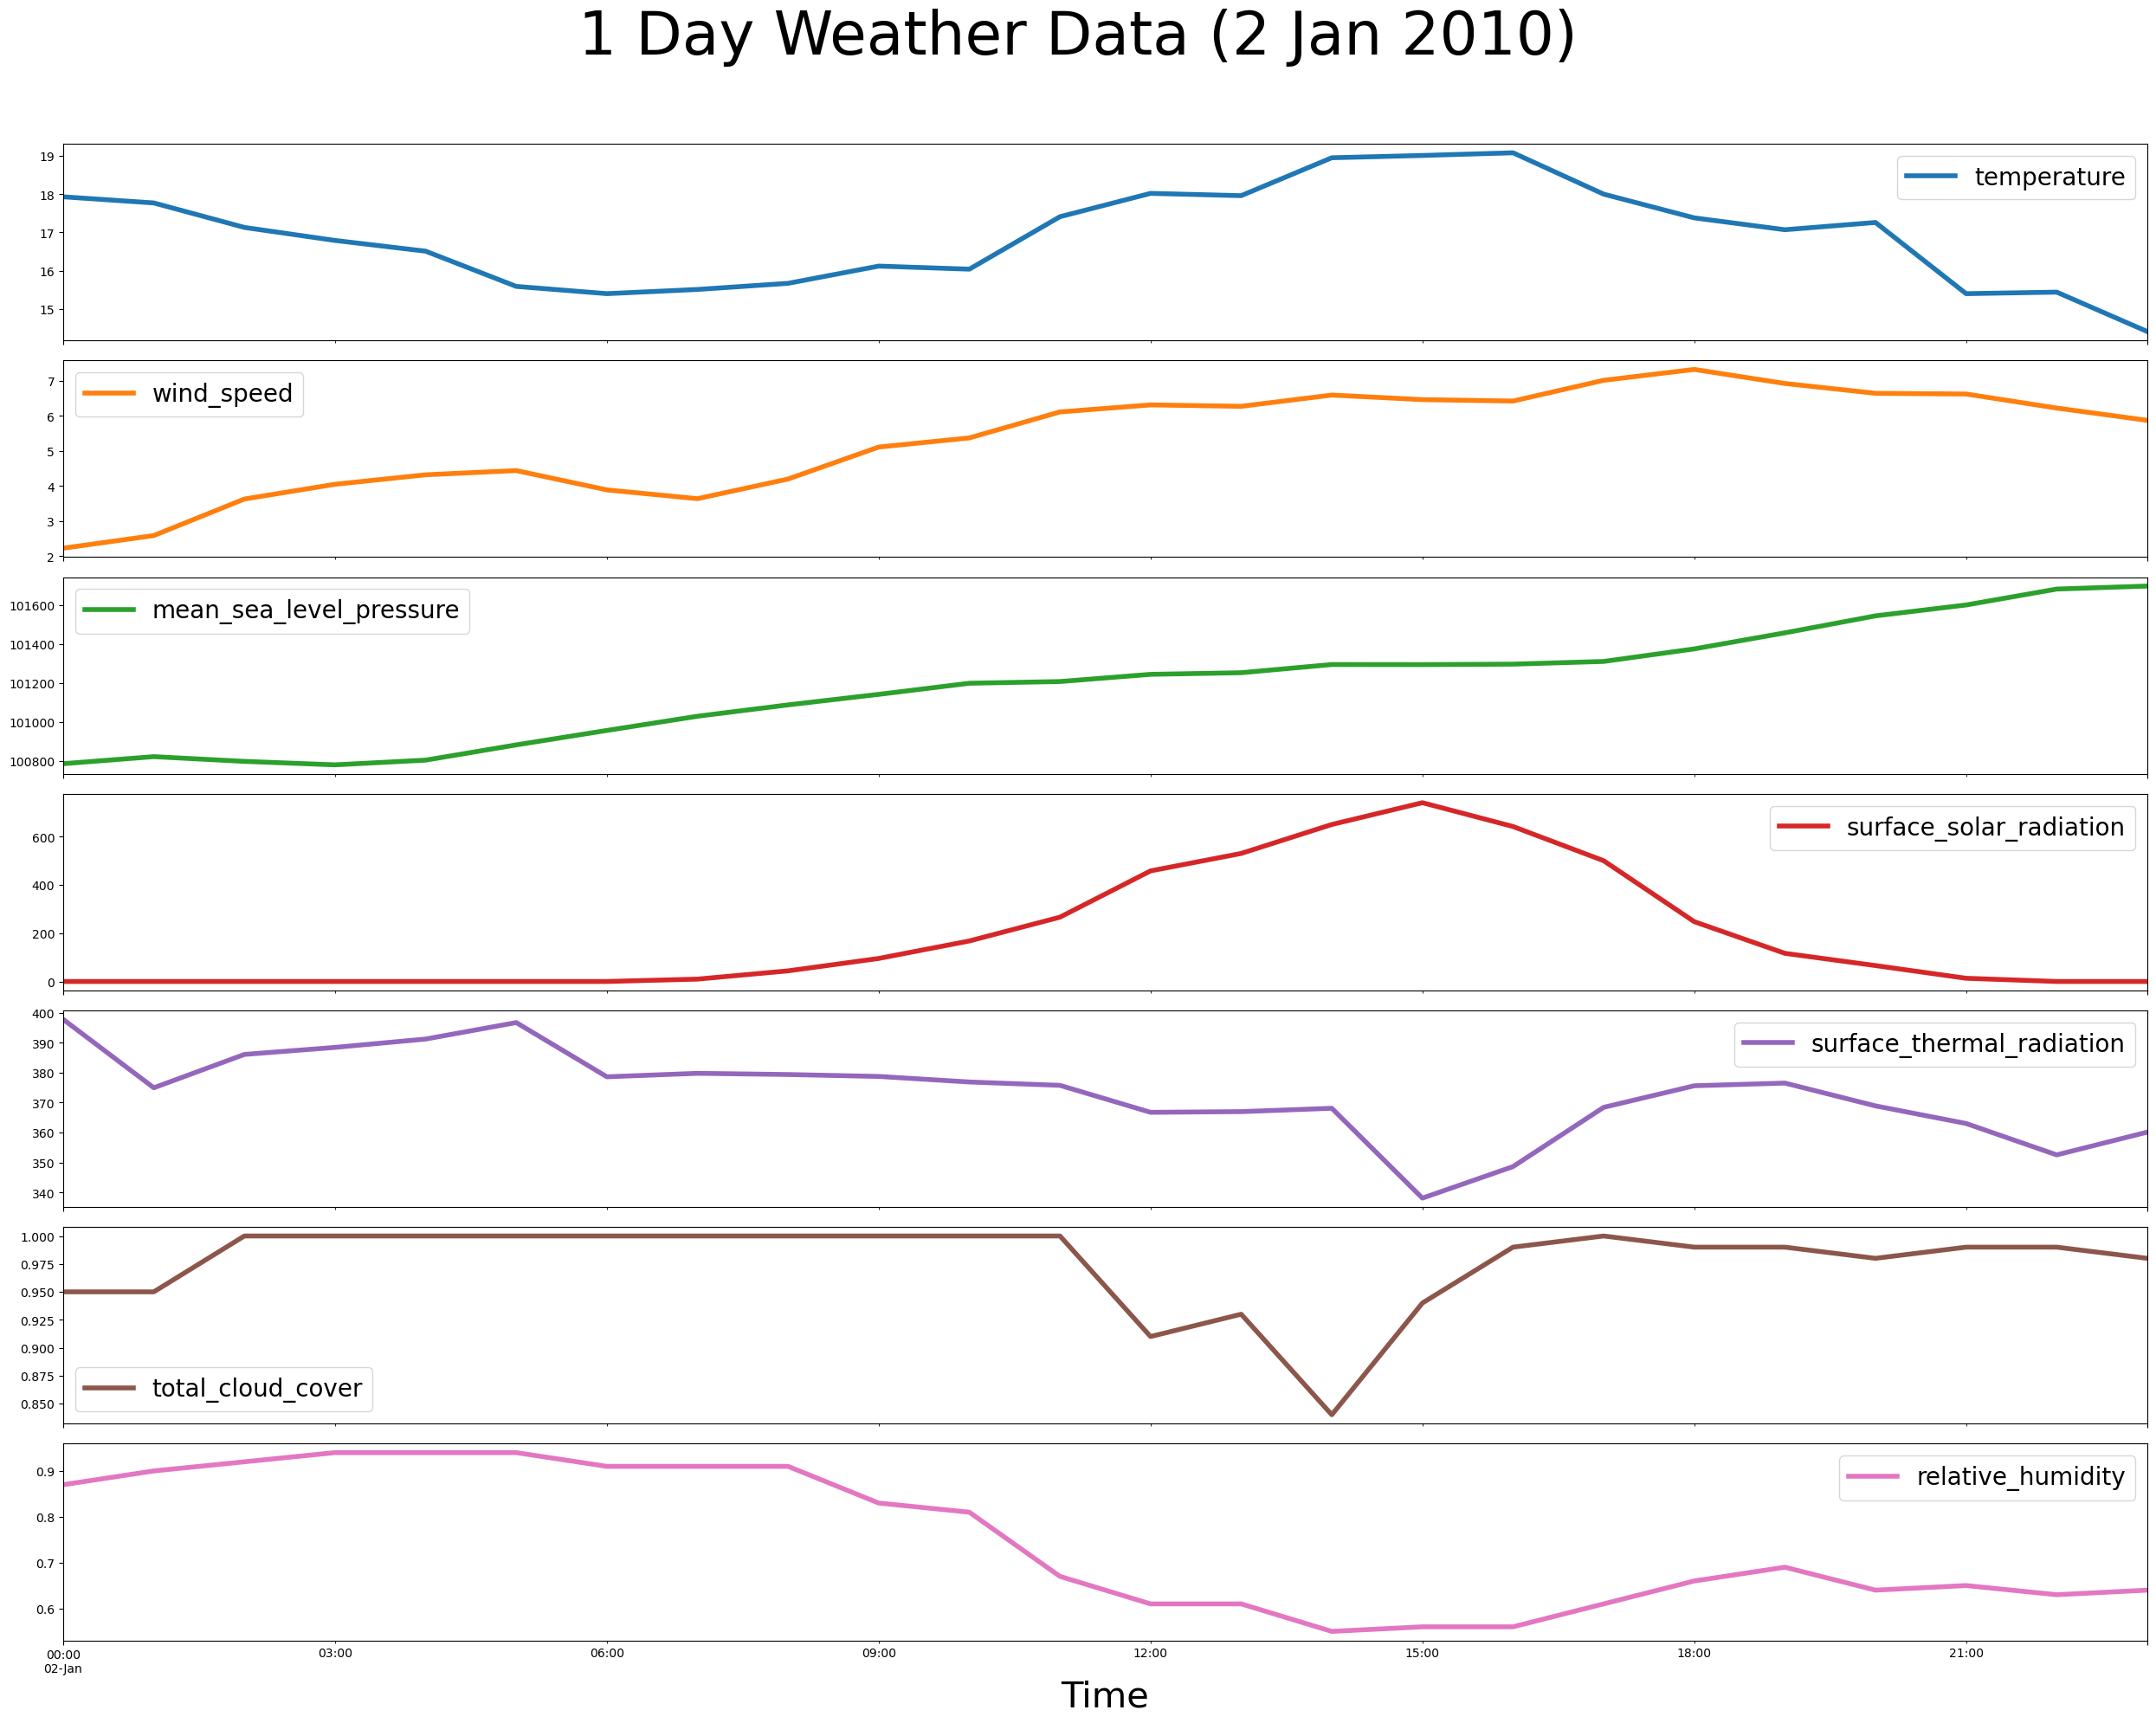

In [11]:
df_time = df.copy()
df_time['date_time'] = pd.date_range(start='1/1/2010 11:00:00', periods=100057, freq='h', tz='Australia/Sydney')

# Plot one day weather data (24 hours of 2 Jan 2010)
one_day = df_time.iloc[13:37, :] 
axes = one_day.plot(
    x='date_time',  
    y=[col for col in one_day.columns if col != 'date_time'], 
    subplots=True, figsize=(25, 20), linewidth=4)
plt.suptitle('1 Day Weather Data (2 Jan 2010)', fontsize=50)
plt.tight_layout(rect=[0, 0, 1, 0.95])

for ax in axes:
    ax.legend(fontsize=20)
    ax.set_xlabel('Time', fontsize = 30)

plt.show()


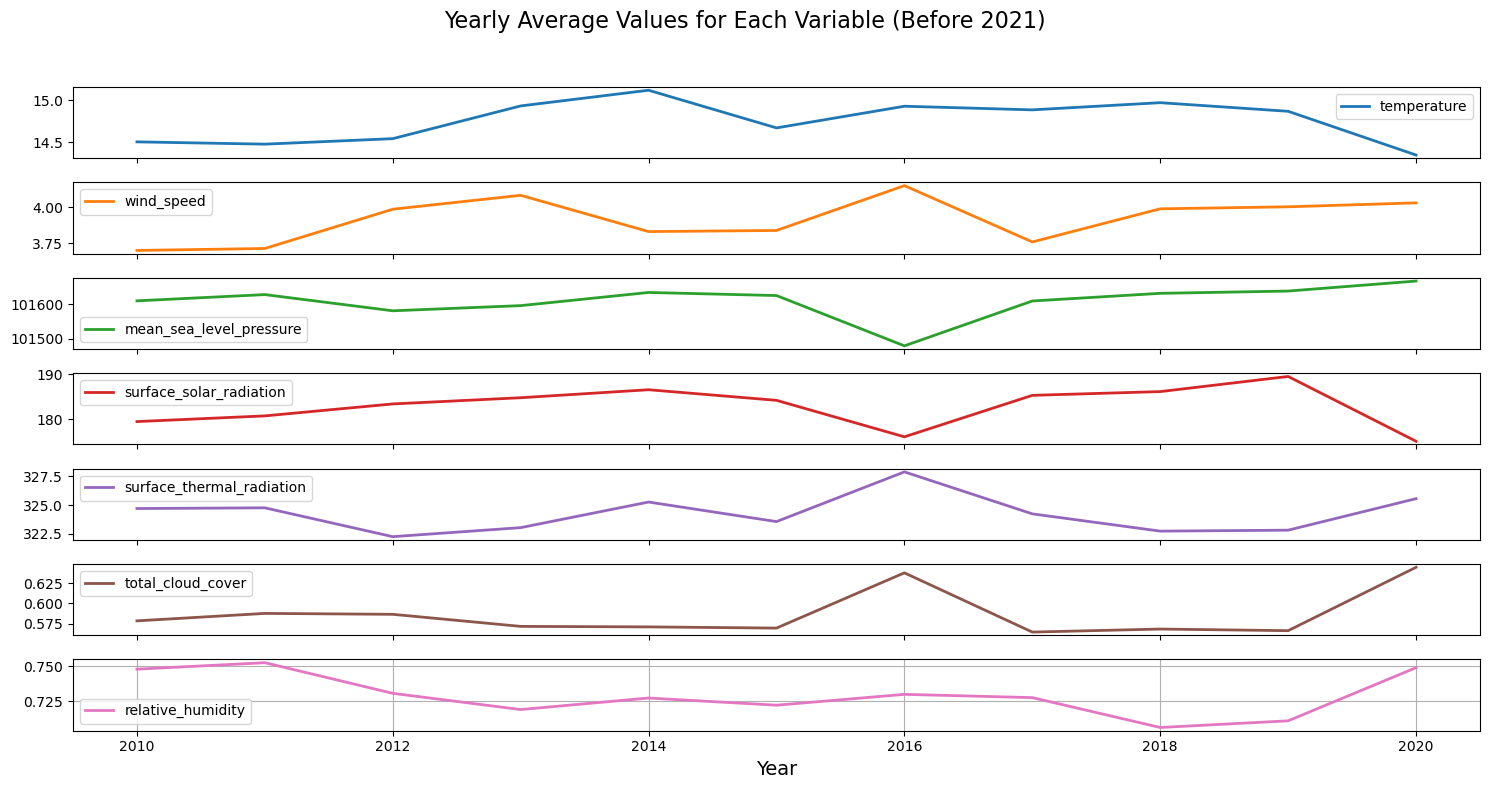

In [12]:
# does global warming have any effect? (probably delete this later)
df_time_dummy = df_time.copy()
df_time_dummy['year'] = df_time_dummy['date_time'].dt.year
# Filter out rows from 2021 onwards since it is incomplete
df_time_dummy = df_time_dummy[df_time_dummy['year'] < 2021]

# Group by year and calculate the mean for each variable
yearly_avg = df_time_dummy.groupby('year').mean()
yearly_avg = yearly_avg.drop(columns=['date_time'])

# Plot the yearly averages
yearly_avg.plot(subplots=True, figsize=(15, 8), linewidth=2)
plt.suptitle('Yearly Average Values for Each Variable (Before 2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.grid(True)
plt.show()

# Seasonal Trends

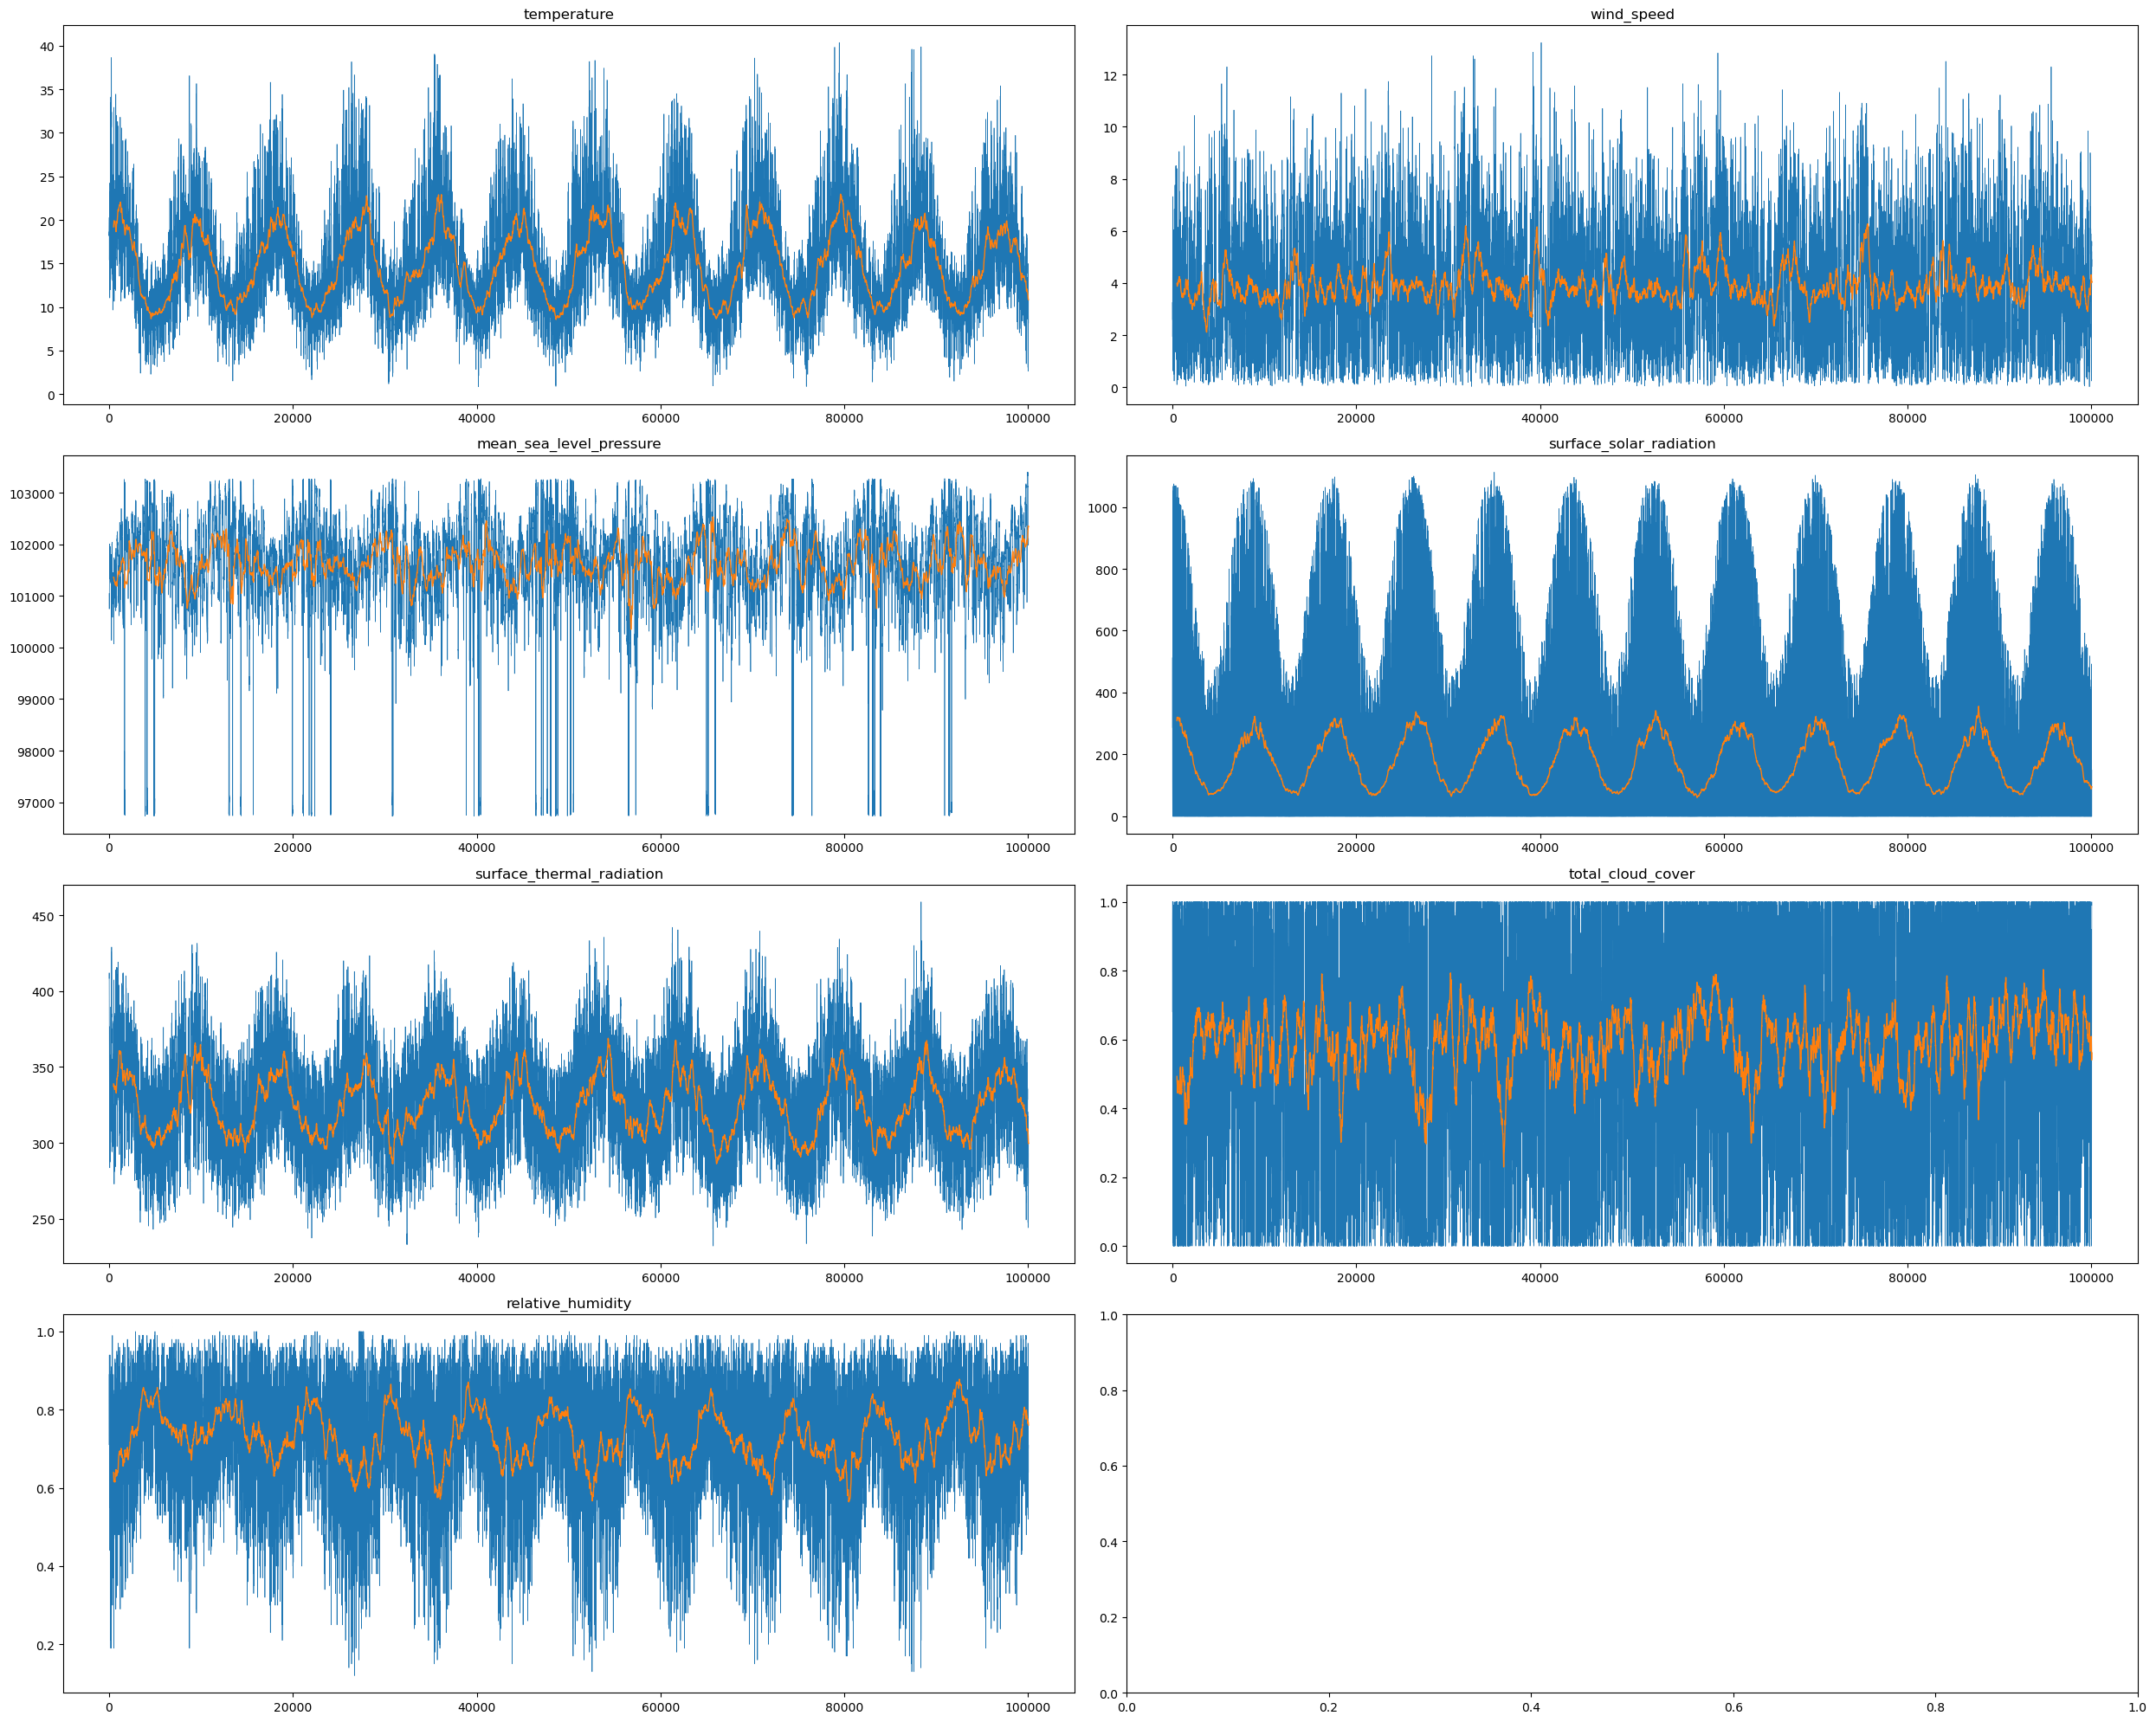

In [13]:
def plot_columns_together(cols, w):
    df_means = pd.DataFrame()
    figure, axis = plt.subplots(4, 2, figsize=(25, 20))
    i = 0
    for col in cols:
        df_col = df[col].rolling(window=w).mean()
        new_col_name = col + "_mean"
        df_means[new_col_name] = df_col

        row_idx = i // 2
        col_idx = i % 2
        ax = axis[row_idx, col_idx]
        ax.plot(df[col], label=col, linewidth=0.5)
        ax.plot(df_col, label=new_col_name, linewidth=1)
        ax.set_title(col)
        i += 1
    figure.tight_layout()
plot_columns_together(df.columns, 480)

# Distribution Analysis

array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'mean_sea_level_pressure'}>],
       [<Axes: title={'center': 'surface_solar_radiation'}>,
        <Axes: title={'center': 'surface_thermal_radiation'}>,
        <Axes: title={'center': 'total_cloud_cover'}>],
       [<Axes: title={'center': 'relative_humidity'}>, <Axes: >,
        <Axes: >]], dtype=object)

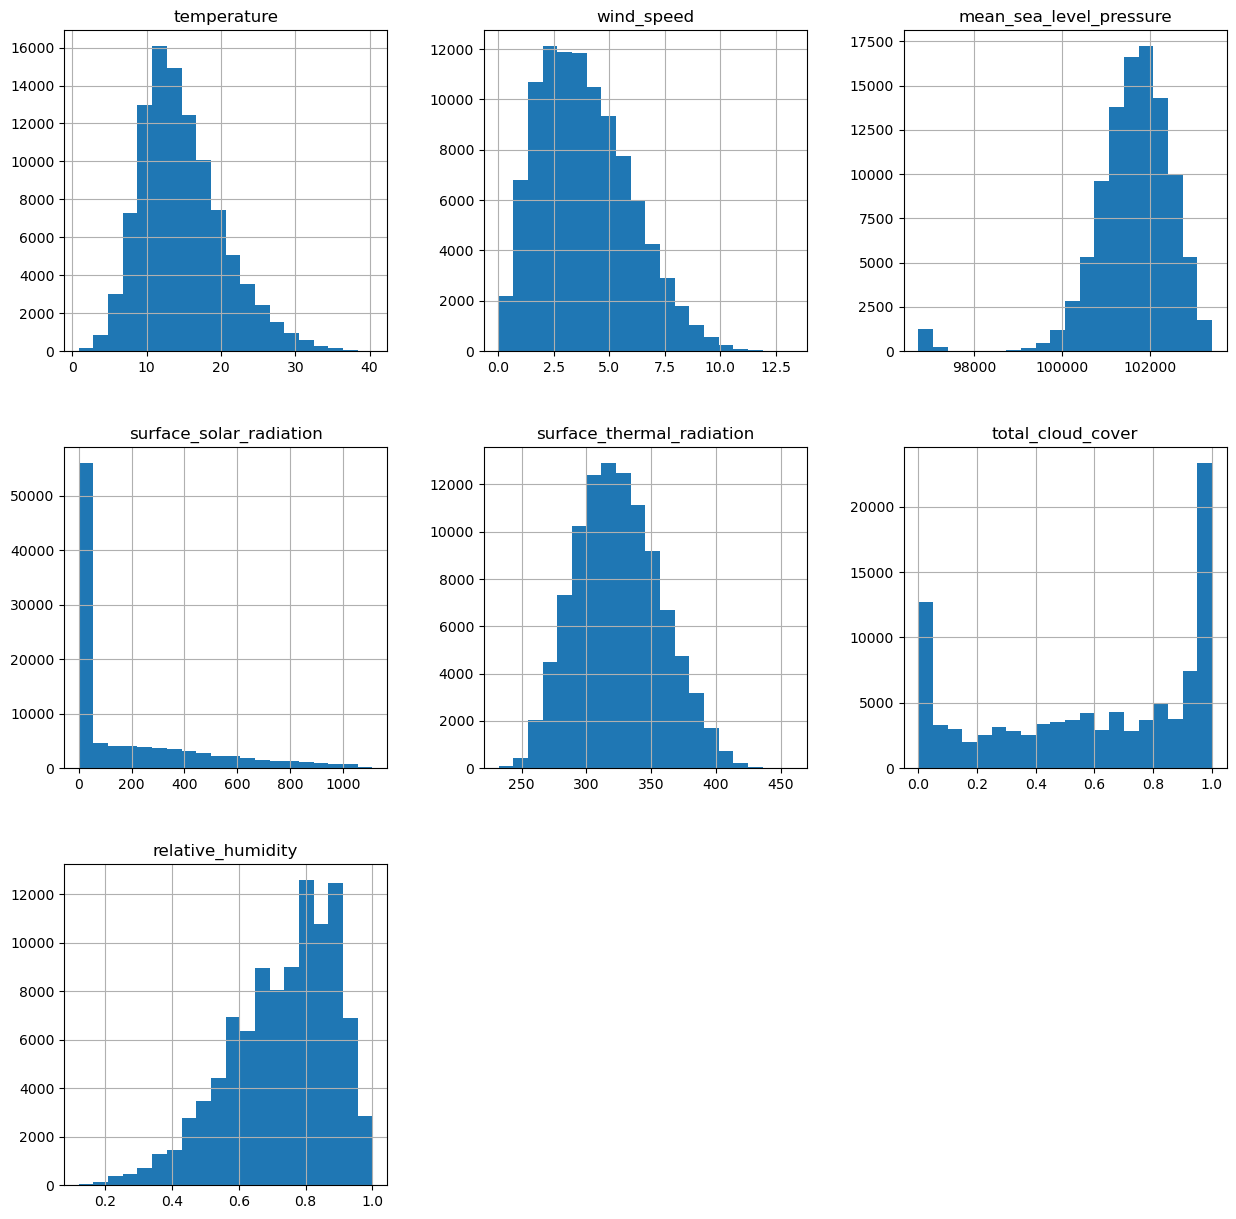

In [14]:
df.hist(bins=20, figsize=(15,15))

Based on the distributions of the variables obtained, we perform standardisation on the following variables, which have roughly normal distributions:
1. temperature
2. wind_speed
3. surface_thermal_radiation
4. relative humidity

However, there are 3 variables with unique distributions that we need to deal with:
1. mean_sea_level_pressure: presence of a small group of anomalies
2. surface_solar_radiation: abundance of extreme values on the left
3. total_cloud_cover: abundance of extreme values on both the right and the left

### Mean sea level pressure

We observe from the histograms above that mean sea level is sometimes much lower than expected. We want to see if there are any patterns in these observations.

In [15]:
special_df = df_time[df_time['mean_sea_level_pressure'] < 98050]
special_df = special_df.copy()
special_df.head()

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity,date_time
1652,12.24,2.52,96764.30,0.00,299.01,0.08,0.81,2010-03-11 07:00:00+11:00
1653,12.49,2.96,96840.68,28.87,290.09,0.07,0.82,2010-03-11 08:00:00+11:00
1654,14.55,2.74,96876.75,198.61,294.88,0.02,0.76,2010-03-11 09:00:00+11:00
1655,14.95,3.58,96908.22,423.48,303.21,0.03,0.74,2010-03-11 10:00:00+11:00
1656,17.31,4.22,96950.93,591.62,304.39,0.13,0.60,2010-03-11 11:00:00+11:00


In [16]:
special_df['mean_sea_level_pressure'].sort_values()

30821    96725.92
48101    96727.49
83953    96728.25
22382    96729.89
83083    96729.90
           ...   
30846    97959.56
15699    97966.15
1661     97978.53
1662     97984.67
50234    98004.63
Name: mean_sea_level_pressure, Length: 1469, dtype: float64

There are a few possible causes of these low pressures:
1. Tropical storms
- 10 Mar 2010: March 2010 Victoria Storms (https://en.wikipedia.org/wiki/March_2010_Victoria_storms#:~:text=The%202010%20Victorian%20storms%20were,winds%20to%20the%20state's%20capital.)
2. Mid-latitude cyclones
3. Deep low-pressure systems

A category 5 hurricane can have pressures as low as 88-95 kPa. So it's probably just a not-so-bad bad weather.

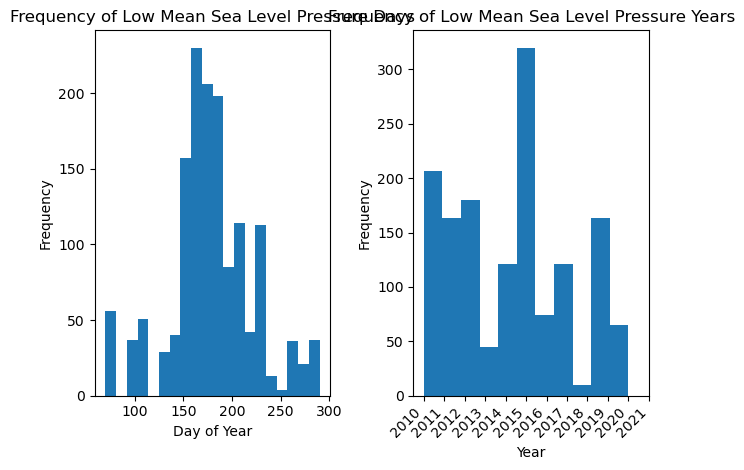

In [17]:
special_df['date'] = special_df['date_time'].apply(lambda x: x.date)

fig1, (ax1, ax2) = plt.subplots(1, 2)

special_df['day_of_year'] = special_df['date_time'].apply(lambda x: x.dayofyear)
ax1.hist(special_df['day_of_year'], bins=20)
ax1.set_xlabel("Day of Year")
ax1.set_ylabel("Frequency")
ax1.set_title("Frequency of Low Mean Sea Level Pressure Days")

special_df['year'] = special_df['date_time'].apply(lambda x: x.year)
ax2.hist(special_df['year'], bins=11)
ax2.set_xticks(range(2010, 2022))
ax2.set_xticklabels(range(2010, 2022))
plt.xticks(rotation=45, ha="right")
ax2.set_xlabel("Year")
ax2.set_ylabel("Frequency")
ax2.set_title("Frequency of Low Mean Sea Level Pressure Years")

fig1.tight_layout()

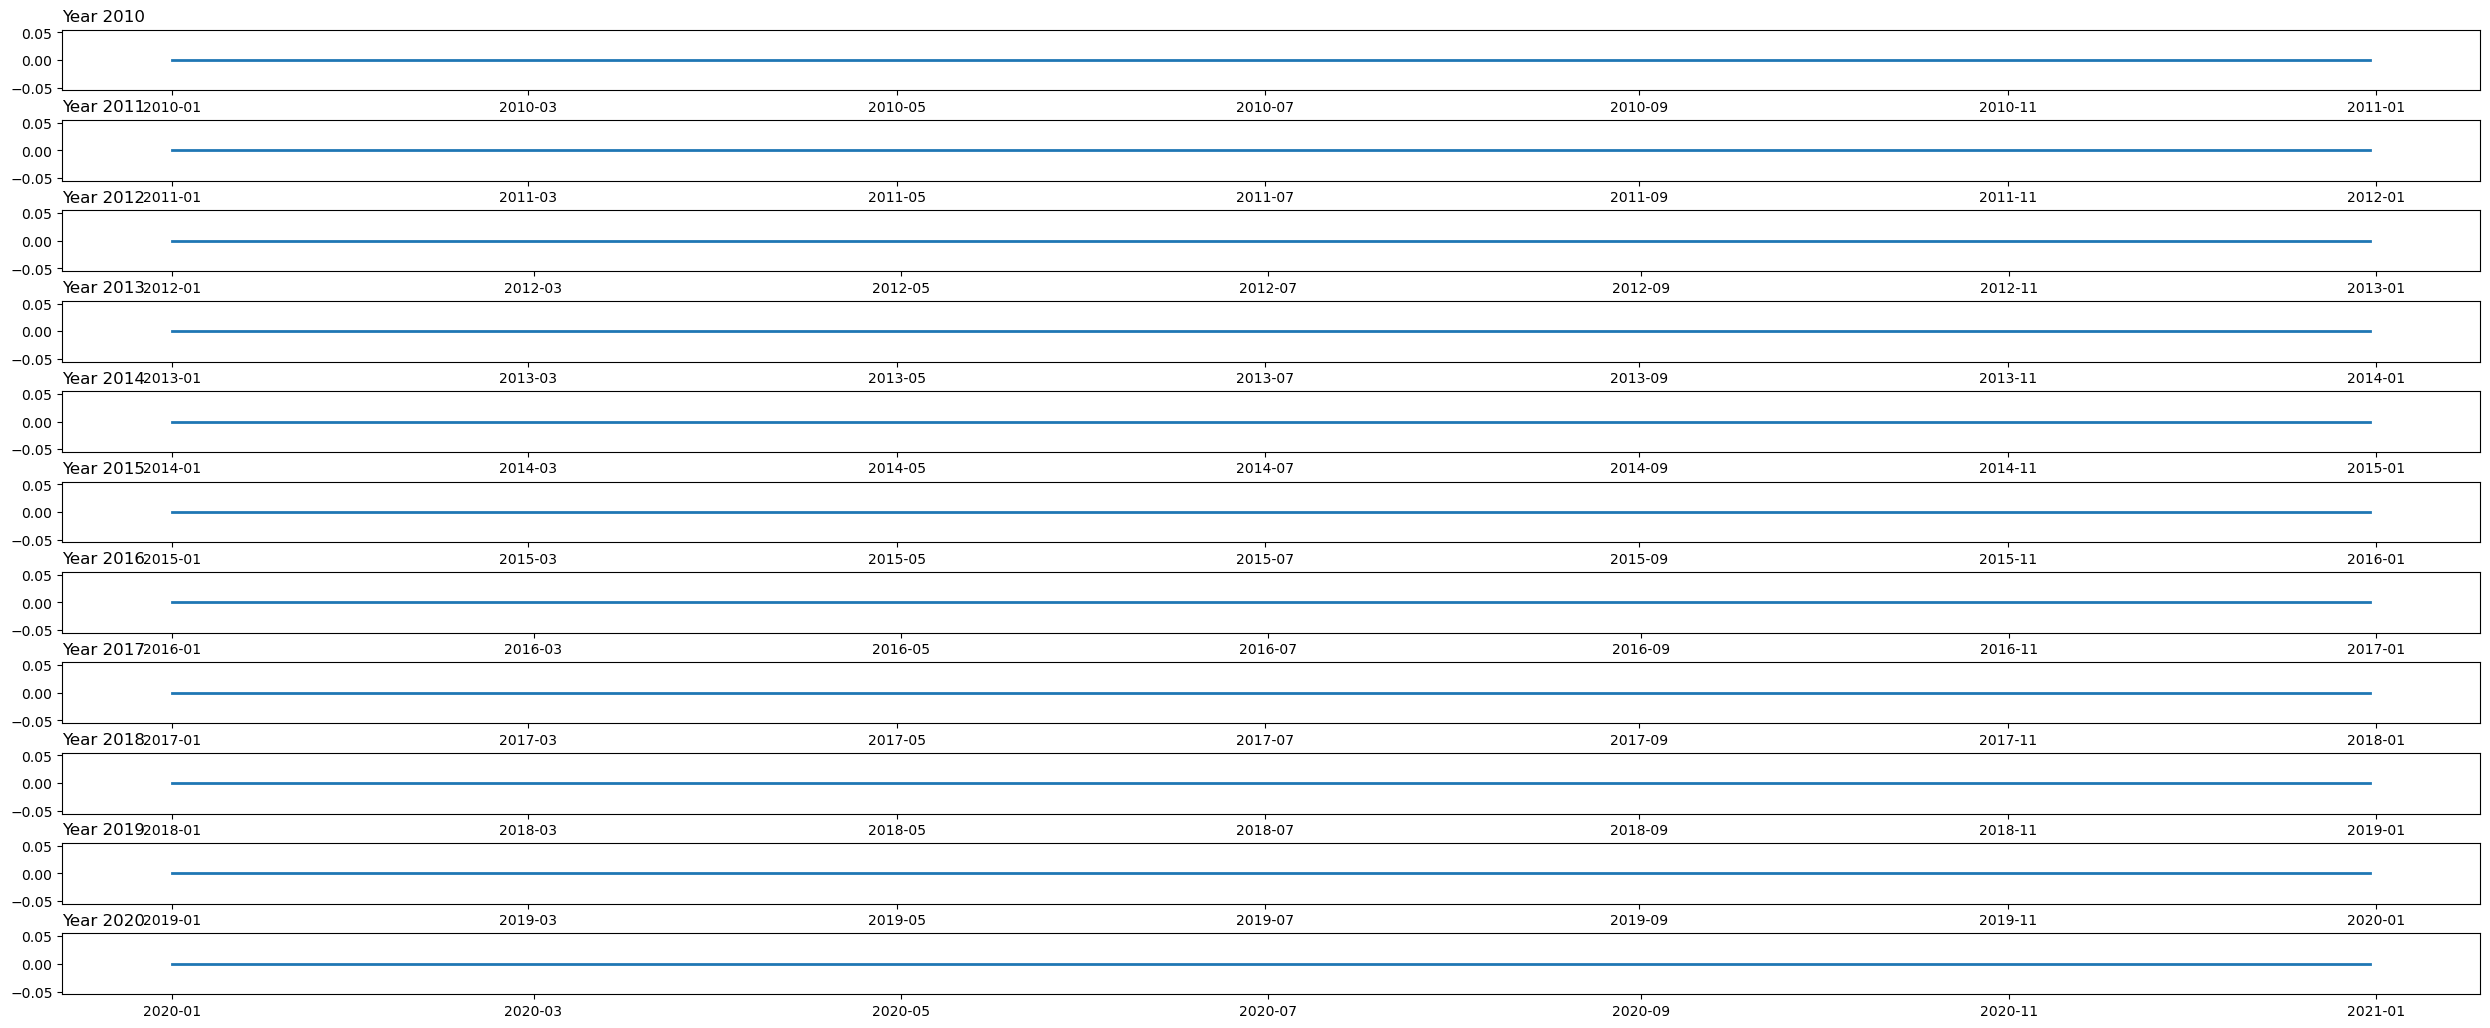

In [18]:
fig_2, ax_2 = plt.subplots(11, 1, figsize=(25, 20))
for i in range(11):
    year = 2010 + i
    to_plot = pd.DataFrame({'dates': pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31").date})
    in_or_not = to_plot.dates.isin(special_df['date'])
    v = np.zeros(len(to_plot))
    for j in range(len(to_plot)):
        if in_or_not[j]:
            v[j] = special_df[special_df['date'] == to_plot.dates[j]]['mean_sea_level_pressure'].mean()
    axis = ax_2[i]
    axis.plot(to_plot['dates'], v, label="Mean Sea Level Pressure", linewidth=2)
    axis.set_title(f"Year {year}", loc='left')

fig_2.tight_layout()
plt.subplots_adjust(bottom=0.5)
plt.show()

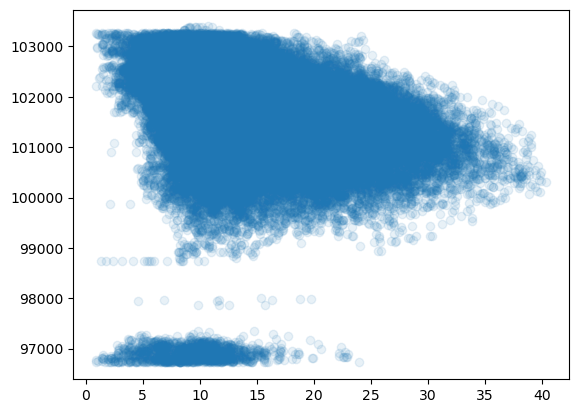

In [19]:
plt.plot(df['temperature'], df['mean_sea_level_pressure'], 'o', alpha=0.1)

Text(0.5, 1.0, 'Mean Sea Level Pressure vs Relative Humidity')

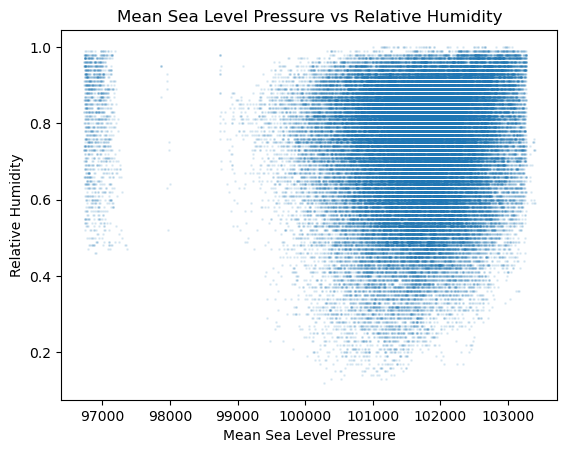

In [20]:
plt.plot(df['mean_sea_level_pressure'][:-5], df['relative_humidity'][5:], 'o', alpha=0.1, markersize=1)
plt.xlabel('Mean Sea Level Pressure')
plt.ylabel('Relative Humidity')
plt.title('Mean Sea Level Pressure vs Relative Humidity')

Low mean sea level pressures tend to be occur more during the middle of the year. This seems to occur quite consistently over the years, except it was very infrequent in 2015 and 2019, and  much higher in 2016.

We can create a dummy variable to mark out these special datapoints.

In [21]:
temp_2 = (df['mean_sea_level_pressure'] < 98000).astype(int).values
df['low_p_dummy'] = temp_2
df_time['low_p_dummy'] = temp_2

### Surface solar radiation

Surface solar radiation is 0 at night (for example, on 1 Jan, it is 0 from 10pm to 7am). We create a day-night dummy to distinguish these 2 timings as there may be different trends between them.

In [22]:
temp_3 = (df['surface_solar_radiation'] > 0).astype(int)
df['day_night_dummy'] = temp_3
df_time['day_night_dummy'] = temp_3

### Total cloud cover

Since the extreme values are expected and not that irregular, we will keep them for now.

# Data Processing

In [23]:
from sklearn.preprocessing import StandardScaler

df_final = df_time.copy()
scaler = StandardScaler()
df_final['temperature'] = scaler.fit_transform(df_time[['temperature']])
df_final['wind_speed'] = scaler.fit_transform(df_time[['wind_speed']])
df_final['mean_sea_level_pressure'] = scaler.fit_transform(df_time[['mean_sea_level_pressure']])
df_final['surface_solar_radiation'] = df_time[['surface_solar_radiation']] / 1000
df_final['surface_thermal_radiation'] = scaler.fit_transform(df_time[['surface_thermal_radiation']])

In [24]:
df_final.head()

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity,date_time,low_p_dummy,day_night_dummy
0,0.620212,-0.638901,-0.612149,0.28701,2.542742,1.0,0.89,2010-01-01 11:00:00+11:00,0,1
1,0.693754,-0.487686,-0.621243,0.36079,2.623822,1.0,0.86,2010-01-01 12:00:00+11:00,0,1
2,0.602274,-0.316959,-0.643601,0.29154,2.613193,1.0,0.87,2010-01-01 13:00:00+11:00,0,1
3,0.656086,-0.360860,-0.637876,0.35711,2.621696,1.0,0.82,2010-01-01 14:00:00+11:00,0,1
4,0.668642,-0.468174,-0.727017,0.45991,2.592848,0.9,0.80,2010-01-01 15:00:00+11:00,0,1


In [25]:
df_final.describe()

,temperature,wind_speed,mean_sea_level_pressure,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover,relative_humidity,low_p_dummy,day_night_dummy
count,1.000570e+05,1.000570e+05,1.000570e+05,100057.000000,1.000570e+05,100057.000000,100057.000000,100057.000000,100057.000000
mean,4.113119e-16,1.443000e-16,4.628963e-15,0.182921,-1.023167e-15,0.587394,0.729183,0.014672,0.541761
std,1.000005e+00,1.000005e+00,1.000005e+00,0.265316,1.000005e+00,0.356411,0.158483,0.120235,0.498255
min,-2.500863e+00,-1.897405e+00,-5.278667e+00,0.000000,-2.807899e+00,0.000000,0.120000,0.000000,0.000000
25%,-7.125229e-01,-7.852391e-01,-4.786916e-01,0.000000,-7.320203e-01,0.270000,0.620000,0.000000,0.000000
50%,-1.582632e-01,-1.169640e-01,9.783207e-02,0.007220,-5.210623e-02,0.650000,0.760000,0.000000,1.000000
75%,5.735749e-01,6.683812e-01,6.356559e-01,0.316230,6.842902e-01,0.940000,0.850000,0.000000,1.000000
max,4.584335e+00,4.546328e+00,1.927323e+00,1.112140,4.073536e+00,1.000000,1.000000,1.000000,1.000000


In [26]:
print(df_final.shape)
train = df_final.iloc[:10000]
test = df_final.iloc[10000:]
print(train.shape, test.shape)
# Move 'relative_humidity' to the last column
columns = [col for col in df_final.columns if col != 'relative_humidity']  
columns.append('relative_humidity')  
df_final = df_final[columns]  


(100057, 10)
(10000, 10) (90057, 10)
